In [66]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 150
import glob, os, json

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc

import scipy.stats as st

# Download HMMER data from the 5 batch jobs using the `03_download_hmmer.py` script

```console
python3 03_download_hmmer.py Data/PFAM_1 497 "https://www.ebi.ac.uk/Tools/hmmer/download/1FE2F0A6-CA49-11EC-974F-F6D253F04F9B."

python3 03_download_hmmer.py Data/PFAM_2 500 "https://www.ebi.ac.uk/Tools/hmmer/download/CB06B1F0-CAEB-11EC-8D9A-2EC1F75AEC3D."

python3 03_download_hmmer.py Data/PFAM_3 499 "https://www.ebi.ac.uk/Tools/hmmer/download/E28DC60E-CAF2-11EC-9059-76DC53F04F9B."

python3 03_download_hmmer.py Data/PFAM_4 499 "https://www.ebi.ac.uk/Tools/hmmer/download/9E92817A-CB05-11EC-9159-81C8DBC3747A."

python3 03_download_hmmer.py Data/PFAM_5 229 "https://www.ebi.ac.uk/Tools/hmmer/download/C12F13AA-CB0B-11EC-9455-13DE53F04F9B."
```

# Combine HMMER data for each protein in a batch using `04_process_hmmer.py`

```console
python3 04_process_hmmer.py Data/PFAM_1 Data/proteins_seq_small_1.fasta Data/PFAM/batch_1

python3 04_process_hmmer.py Data/PFAM_2 Data/proteins_seq_small_2.fasta Data/PFAM/batch_2

python3 04_process_hmmer.py Data/PFAM_3 Data/proteins_seq_small_3.fasta Data/PFAM/batch_3

python3 04_process_hmmer.py Data/PFAM_4 Data/proteins_seq_small_4.fasta Data/PFAM/batch_4

python3 04_process_hmmer.py Data/PFAM_5 Data/proteins_seq_small_5.fasta Data/PFAM/batch_5
```

In [3]:
# 5 batch files were previously combined into this file
df = pd.read_csv("../Data/protein_domains.csv")

# 5 Proteins longer than 5000 had to be queried using their UniProt ID

## Following esults determined manually

Q9NU22: 8 AAA_5, 3 AAA_lid_7, 1 AAA_lid_5

P58107: 36 Plectin

Q8NF91: 2 CH, 10 Spectrin, 1 KASH

Q03001: 2 CH, 20 Spectrin, 1 SH3_10, 1 Spectrin-like, 1 Plectin, 1 EF-hand_7, 1 GAS2

Q09666: 0 (only disordered and low complexity regions)

## Encode them in dataframes as follows:

In [4]:
df_2 = pd.DataFrame({'UniProt': ['Q9NU22', 'Q9NU22', 'Q9NU22'], 'PFAM': ['AAA_5', 'AAA_lid_7', 'AAA_lid_5'], 'Count': [8, 3, 1]})
df_3 = pd.DataFrame({'UniProt': ['P58107'], 'PFAM': ['Plectin'], 'Count': [36]})
df_4 = pd.DataFrame({'UniProt': ['Q8NF91', 'Q8NF91', 'Q8NF91'], 'PFAM': ['CH', 'Spectrin', 'KASH'], 'Count': [2, 10, 1]})
df_5 = pd.DataFrame({'UniProt': ['Q03001', 'Q03001', 'Q03001', 'Q03001', 'Q03001', 'Q03001', 'Q03001'], 'PFAM': ['CH', 'Spectrin', 'SH3_10', 'Spectrin_like', 'Plectin', 'EF-hand_7', 'GAS2'], 'Count': [2, 20, 1, 1, 1, 1, 1]})

# combine with the large dataframe to get a final dataframe of protein domains
df_final = pd.concat([df, df_2, df_3, df_4, df_5]).reset_index(drop=True)


# Distribution of Protein Domains in the dataset

In [5]:
# sum all the numbers of domains
#pd.DataFrame(df.groupby("PFAM")["Count"].sum()).sort_values("Count", ascending=False)

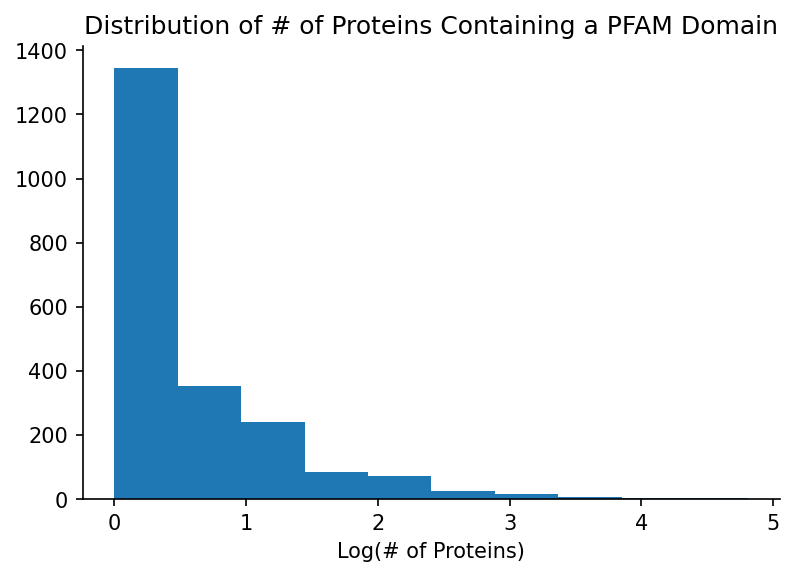

In [6]:
# count the number of proteins containing a given domain
summary_df = pd.DataFrame(df.groupby("PFAM")["UniProt"].count()).sort_values("UniProt", ascending=False).reset_index()
plt.hist(np.log(summary_df["UniProt"]))

plt.title("Distribution of # of Proteins Containing a PFAM Domain")
plt.xlabel("Log(# of Proteins)")
sns.despine()
plt.show()

# Take the top 10 domains?

In [7]:
domains_high = summary_df.PFAM.values[:10]
domains_high

array(['PK_Tyr_Ser-Thr', 'Pkinase', 'RRM_1', 'Helicase_C', 'SH3_1',
       'SH3_2', 'SH3_9', 'SH2', 'DEAD', 'PDZ'], dtype=object)

In [8]:
# convert to matrix format for the following analyses
matrix_domains_high = df.loc[df.PFAM.isin(domains_high)].pivot(index="UniProt", columns="PFAM", values="Count").fillna(0).astype(int)

In [9]:
matrix_domains_high

PFAM,DEAD,Helicase_C,PDZ,PK_Tyr_Ser-Thr,Pkinase,RRM_1,SH2,SH3_1,SH3_2,SH3_9
UniProt,,,,,,,,,,
A0A024RD18,0,0,0,2,1,0,0,0,0,0
A0A087X0X3,0,0,0,0,0,3,0,0,0,0
A0A0S2Z4W4,0,0,0,0,0,1,0,0,0,0
A0AV96,0,0,0,0,0,3,0,0,0,0
A6NFN3,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
Q9Y5S9,0,0,0,0,0,1,0,0,0,0
Q9Y5X1,0,0,0,0,0,0,0,1,1,1
Q9Y6M1,0,0,0,0,0,2,0,0,0,0


# Unsupervised Learning and Clustering

## Principal Components Analysis

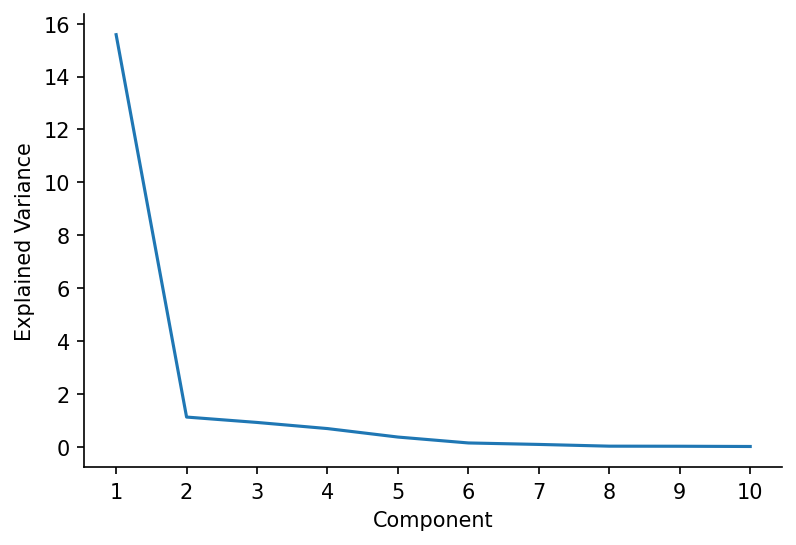

In [180]:
# first check using the elbow method
n = 10
pca_large = PCA(n_components=n).fit(matrix_domains_high.values)

plt.plot(np.arange(1, n+1), pca_large.explained_variance_)
sns.despine()
plt.xticks(np.arange(1, n+1))
plt.xlabel("Component")
plt.ylabel("Explained Variance")
plt.show()

## Clustering with DBSCAN

Picked `min_samples=3` arbitrarily (because it felt reasonable). Turns out `min_samples=2` or `min_samples=4` doesn't give such a nice cluster gradient with PC1. 

In [167]:
def perform_plot_dbscan(data, min_samples=3, title=None):

    dbscan = DBSCAN(min_samples=min_samples).fit(data.values)
    print(f"{np.max(dbscan.labels_)+1} clusters found")

    pca = PCA(n_components=2).fit(data.values)
    
    print(f"Explained variances: {pca.explained_variance_}")
    
    pca_transformed = pca.transform(data.values)
    
    pca_df = pd.DataFrame(pca_transformed)

    pca_df.columns = ["PC1", "PC2"]

    pca_df["UniProt"] = data.index

    # -1 cluster means too disordered
    pca_df["Cluster"] = dbscan.labels_
    
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="viridis")
    sns.despine()
    plt.title(title)
    plt.show()

18 clusters found
Explained variances: [15.58348249  1.12447455]


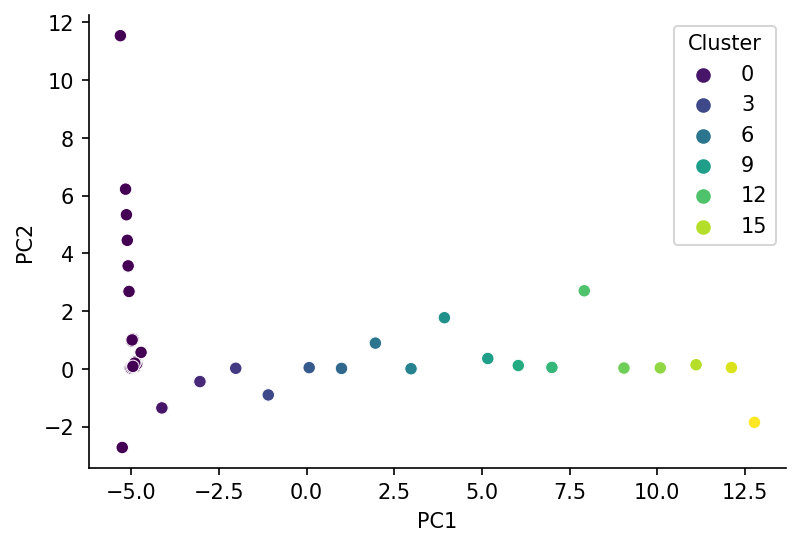

In [168]:
perform_plot_dbscan(matrix_domains_high)

### Interesting, so this means that principal component 1 correlates with cluster

### So maybe look at which PFAM domains are most strongly correlated (+/-) with PC1 to find things that differ 

## Can further investigate cluster 0 since PC2 variation is only in that cluster essentially

In [169]:
spearman_res = [[matrix_domains_high.columns[i], st.spearmanr(pca_df.PC1, matrix_domains_high.iloc[:, i])] for i in range(n)]

pvalues_pc1, spearman_rhos_pc1 = list(zip(*spearman_res))

In [170]:
for domain, res in spearman_res:
    
    if res[1] < 0.05:
        print(domain, res[0])

DEAD -0.21931662690049109
PK_Tyr_Ser-Thr 0.3181488947257457
Pkinase 0.3310607148413526
RRM_1 -0.4423969946470358
SH2 0.11313208588567478
SH3_2 0.20770581755611003
SH3_9 0.18171337914387461


# Compare these clusters to GO functions to see if proteins that share PFAM domains share GO functions

In [171]:
GO_proteins = pd.read_csv("../Processed/enriched_GO_proteins.csv")
GO_small = GO_proteins.loc[GO_proteins["UniProt"].isin(matrix_domains_high.index)]

# put it in matrix form
matrix_GO = GO_small.pivot(index="Gene", columns="GO")
matrix_GO = matrix_GO.where(~matrix_GO. notna(), 1)
matrix_GO = matrix_GO.fillna(0)

In [194]:
# number of proteins that each GO is associated with
summary_go_df = pd.DataFrame(GO_small.groupby("GO")["Gene"].count()).reset_index().sort_values("Gene", ascending=False).reset_index(drop=True)
summary_go_df.columns = ["GO", "num_proteins"]

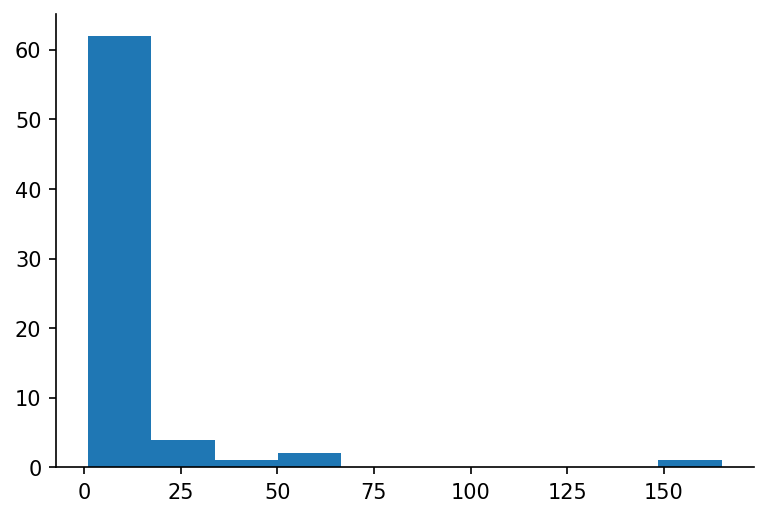

In [198]:
plt.hist(summary_go_df.num_proteins.values)
sns.despine()
plt.show()

# Take top positive and top negative correlations, compare to high and low cluster #s

In [206]:
# these are the 2229 proteins that were queried on PFAM for their domain
GO_jaccard_perfect_overlap = pd.read_csv("../Processed/jaccard_perfect_overlap.csv")

In [207]:
GO_jaccard_perfect_overlap

,gene_1,gene_2,Jaccard,uniprot_1,uniprot_2,seq_1,seq_2
0,A1CF,HNRNPC,1.0,Q9NQ94,P07910,MESNHKSGDGLSGTQKEAALRALVQRTGYSLVQENGQRKYGGPPPG...,MASNVTNKTDPRSMNSRVFIGNLNTLVVKKSDVEAIFSKYGKIVGC...
1,A1CF,RBMX,1.0,Q9NQ94,P38159,MESNHKSGDGLSGTQKEAALRALVQRTGYSLVQENGQRKYGGPPPG...,MVEADRPGKLFIGGLNTETNEKALEAVFGKYGRIVEVLLMKDRETN...
2,A1CF,SSB,1.0,Q9NQ94,P05455,MESNHKSGDGLSGTQKEAALRALVQRTGYSLVQENGQRKYGGPPPG...,MAENGDNEKMAALEAKICHQIEYYFGDFNLPRDKFLKEQIKLDEGW...
3,A2M,A2ML1,1.0,P01023,A8K2U0,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,MWAQLLLGMLALSPAIAEELPNYLVTLPARLNFPSVQKVCLDLSPG...
4,A2M,ADAMTSL4,1.0,P01023,Q6UY14,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,MENWTGRPWLYLLLLLSLPQLCLDQEVLSGHSLQTPTEEGQGPEGV...
...,...,...,...,...,...,...,...
103205,ZNF74,ZRANB2,1.0,Q16587,O95218,MEIPAPEPEKTALSSQDPALSLKENLEDISGWGLPEARSKESVSFK...,MSTKNFRVSDGDWICPDKKCGNVNFARRTSCNRCGREKTTEAKMMK...
103206,ZNF74,ZYX,1.0,Q16587,H0Y2Y8,MEIPAPEPEKTALSSQDPALSLKENLEDISGWGLPEARSKESVSFK...,AAPRPSPAISVSVSAPAFYAPQKKFGPVVAPKPKVNPFRPGDSEPP...
103207,ZNF768,ZRANB2,1.0,Q9H5H4,O95218,MEREALPWGLEPQDVQSSDEMRSPEGYLRGNMSENEEEEISQQEGS...,MSTKNFRVSDGDWICPDKKCGNVNFARRTSCNRCGREKTTEAKMMK...
103208,ZNF768,ZYX,1.0,Q9H5H4,H0Y2Y8,MEREALPWGLEPQDVQSSDEMRSPEGYLRGNMSENEEEEISQQEGS...,AAPRPSPAISVSVSAPAFYAPQKKFGPVVAPKPKVNPFRPGDSEPP...


## For each pair in the above dataframe, compute how many PFAM domains they share

In [208]:
matrix_domains_high

PFAM,DEAD,Helicase_C,PDZ,PK_Tyr_Ser-Thr,Pkinase,RRM_1,SH2,SH3_1,SH3_2,SH3_9,Cluster
UniProt,,,,,,,,,,,
A0A024RD18,0,0,0,2,1,0,0,0,0,0,-1
A0A087X0X3,0,0,0,0,0,3,0,0,0,0,0
A0A0S2Z4W4,0,0,0,0,0,1,0,0,0,0,1
A0AV96,0,0,0,0,0,3,0,0,0,0,0
A6NFN3,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
Q9Y5S9,0,0,0,0,0,1,0,0,0,0,1
Q9Y5X1,0,0,0,0,0,0,0,1,1,1,10
Q9Y6M1,0,0,0,0,0,2,0,0,0,0,3


## `perform_plot_dbscan(matrix_GO)` is not informative because the points cluster VERY poorly in PCA

In [ ]:
# hierarchical clustering -- idk, might be useful, we'll see
# plt.figure(figsize=(10, 7))
# plt.title("Customer Dendograms")
# dend = shc.dendrogram(shc.linkage(matrix_domains_high.values, method='ward'))